In [ ]:
import scipy
import numpy as np
import pandas as pd
from natsort import natsorted 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 14})
import pickle
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical
from data_utils import reorganize_rois, reorder_hemispheres, load_aperiodic_from_mat_files
import pickle

In [ ]:
# Load the dictionary from the file
with open("path\\to\\fooof\\exponent\\pkl\\data", 'rb') as file:
    fooof_exponent_dict = pickle.load(file)

In [ ]:
### LOADING ROIs NAME FROM EEGLAB DESIKAN ATLAS ###
labels = pd.read_excel('path/to/EEGLAB/Desikan/atlas/xlsx').values.tolist()
labels = [parcel_name[0].replace("'", "") for parcel_name in labels]
print(f'ROIs names: {labels}')

ROIs names: ['bankssts L', 'bankssts R', 'caudalanteriorcingulate L', 'caudalanteriorcingulate R', 'caudalmiddlefrontal L', 'caudalmiddlefrontal R', 'cuneus L', 'cuneus R', 'entorhinal L', 'entorhinal R', 'frontalpole L', 'frontalpole R', 'fusiform L', 'fusiform R', 'inferiorparietal L', 'inferiorparietal R', 'inferiortemporal L', 'inferiortemporal R', 'insula L', 'insula R', 'isthmuscingulate L', 'isthmuscingulate R', 'lateraloccipital L', 'lateraloccipital R', 'lateralorbitofrontal L', 'lateralorbitofrontal R', 'lingual L', 'lingual R', 'medialorbitofrontal L', 'medialorbitofrontal R', 'middletemporal L', 'middletemporal R', 'paracentral L', 'paracentral R', 'parahippocampal L', 'parahippocampal R', 'parsopercularis L', 'parsopercularis R', 'parsorbitalis L', 'parsorbitalis R', 'parstriangularis L', 'parstriangularis R', 'pericalcarine L', 'pericalcarine R', 'postcentral L', 'postcentral R', 'posteriorcingulate L', 'posteriorcingulate R', 'precentral L', 'precentral R', 'precuneus L'

#### CORRELATION FOOOF - THICKNESS

In [ ]:
path = 'path/to/cortical/thickness/mat/data'
cortical_thickness_data = scipy.io.loadmat(path + "Cor_thick_exp_pre_ictal.mat")['Thick_exp_corr']

In [5]:
cortical_thickness_dict = {cortical_thickness_data[0][1][0]: {'rho': cortical_thickness_data[1][1], 'pval': cortical_thickness_data[2][1]},
                            cortical_thickness_data[0][2][0]: {'rho': cortical_thickness_data[1][2], 'pval': cortical_thickness_data[2][2]},
                            cortical_thickness_data[0][3][0]: {'rho': cortical_thickness_data[1][3], 'pval': cortical_thickness_data[2][3]},
                            cortical_thickness_data[0][4][0]: {'rho': cortical_thickness_data[1][4], 'pval': cortical_thickness_data[2][4]}
                            }

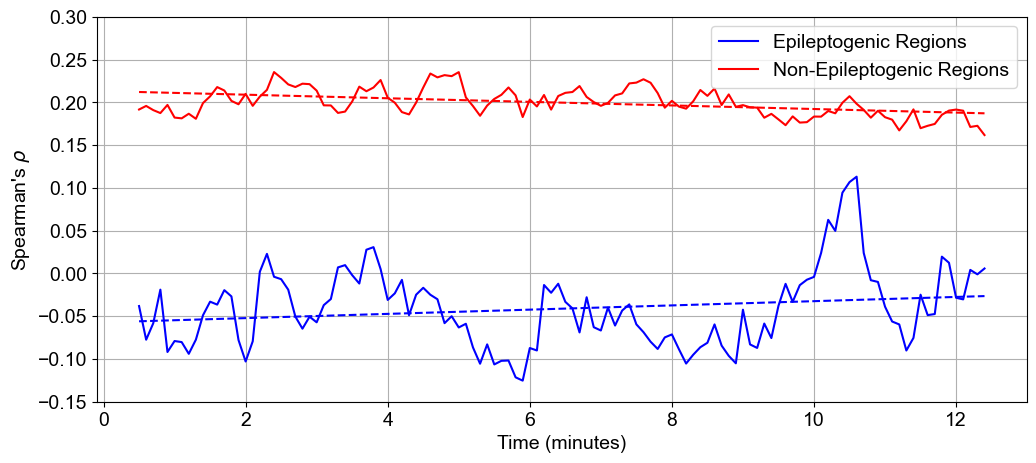

In [8]:
# Parameters
ampling_rate = 256  # Sampling frequency in Hz
signal_duration_sec = 13 * 60  # Total duration of signal in seconds (13 minutes = 780 seconds)
window_length_sec = 60  # Sliding window length in seconds
step_size_sec = window_length_sec * (1 - 0.9)  # Step size between windows (90% overlap → 6 seconds)
num_segments = 121  # Number of sliding windows

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:120]

# Plot the two time series
plt.figure(figsize=(12, 5))

# Plot Selected Indices with std halo
x1 = window_center_times_min
plt.plot(x1, cortical_thickness_dict['Epi-time']['rho'], label="Epileptogenic Regions", color="blue")

# Fit a first-degree (linear) polynomial to the Spearman's 
# rho values over time for epileptogenic regions
coeffs_sel = np.polyfit(x1, cortical_thickness_dict['Epi-time']['rho'], 1)
plt.plot(x1, np.polyval(coeffs_sel, x1), linestyle='--', color='blue')

# Plot Non-Selected Indices with std halo
x2 = window_center_times_min
plt.plot(x2, cortical_thickness_dict['No-Epi-time']['rho'], label="Non-Epileptogenic Regions", color="red")

# Fit a first-degree (linear) polynomial to the Spearman's 
# rho values over time for non-epileptogenic regions
coeffs_non = np.polyfit(x2, cortical_thickness_dict['No-Epi-time']['rho'], 1)
plt.plot(x2, np.polyval(coeffs_non, x2), linestyle='--', color='red')

# Add labels and legend
plt.xlabel("Time (minutes)", fontsize = 14)
plt.ylabel(r"Spearman's $\rho$")
#plt.title("Pre-ictal")
plt.legend(loc = 'upper right')
plt.ylim(-0.15,0.3)
plt.grid(True)

# Show the plot
plt.show()

#### PLOTTING 2 SEPARATES CORTICAL PLOTS FOR EPI REGIONS AND NON-EPI REGIONS

In [ ]:
### LOADING EXCEL FILE WITH THE INDICES OF RELEVANT ROIs FOR EACH SUBJECT ###
file_path = "path/to/xlsx/file/containing/epi/rois/indices" 
df_relevant_rois = pd.read_excel(file_path)
# Extract indices and IDs
list_indices =  list(zip(df_relevant_rois["ID"].tolist(), list(df_relevant_rois["INDICES_strict"].tolist())))

# Initialize an empty list to store all epileptogenic ROI indices
all_epi_rois = []

# Iterate over the list of tuples containing (label, comma-separated string of numbers)
for _, numbers_str in list_indices:
    
    # Split the string by commas, strip whitespace, convert each element to an integer
    nums = [int(n.strip()) for n in numbers_str.split(',')]
    
    # Append each integer ROI index to the master list of epileptogenic ROIs
    for i in nums:
        all_epi_rois.append(i)

In [ ]:
# Initialize an empty list to store all epileptogenic ROI indices
all_nonepi_rois = []
# Iterate over the list of tuples containing (label, comma-separated string of numbers)
for _, numbers_str in list_indices:
    # Split the string by commas, strip whitespace, convert each element to an integer
    nums = [int(n.strip()) for n in numbers_str.split(',')]
    full_range = set(range(68))
    missing = full_range - set(nums)
    all_nonepi_rois.extend(missing)  # Add the missing ones

In [ ]:
# Count the frequency of each unique ROI index in the all_epi_rois list
# 'unique' contains the distinct ROI indices
# 'counts' contains how many times each ROI appears
unique, counts = np.unique(all_epi_rois, return_counts=True)
# Create a dictionary mapping each ROI index to its count (i.e., number of occurrences)
rois_count = dict(zip(unique, counts))
# Initialize a mask (array) of size 68 (e.g., assuming 68 cortical ROIs) with zeros
mask_epi = np.full(68, 0)  
# Populate the mask: for each ROI index from 0 to 67,
# if it exists in the dictionary, assign its count to the corresponding index
for i in range(68):
    if i in rois_count.keys():
        mask_epi[i] = rois_count[i]

print(mask_epi)

[0 0 0 0 3 0 0 0 8 0 8 4 8 0 4 2 1 0 0 0 0 0 0 0 8 4 0 0 8 4 1 0 3 2 7 0 7
 4 7 4 7 4 0 0 4 2 0 0 4 0 0 2 8 4 8 4 3 0 4 2 1 0 4 2 8 0 0 0]


In [ ]:
# Count the frequency of each unique ROI index in the all_epi_rois list
# 'unique' contains the distinct ROI indices
# 'counts' contains how many times each ROI appears
unique, counts = np.unique(all_nonepi_rois, return_counts=True)
# Create a dictionary mapping each ROI index to its count (i.e., number of occurrences)
rois_count = dict(zip(unique, counts))
# Initialize a mask (array) of size 68 (e.g., assuming 68 cortical ROIs) with zeros
mask_nonepi = np.full(68, 0)  
# Populate the mask: for each ROI index from 0 to 67,
# if it exists in the dictionary, assign its count to the corresponding index
for i in range(68):
    if i in rois_count.keys():
        mask_nonepi[i] = rois_count[i]

print(mask_nonepi)

[29 29 29 29 26 29 29 29 21 29 21 25 21 29 25 27 28 29 29 29 29 29 29 29
 21 25 29 29 21 25 28 29 26 27 22 29 22 25 22 25 22 25 29 29 25 27 29 29
 25 29 29 27 21 25 21 25 26 29 25 27 28 29 25 27 21 29 29 29]


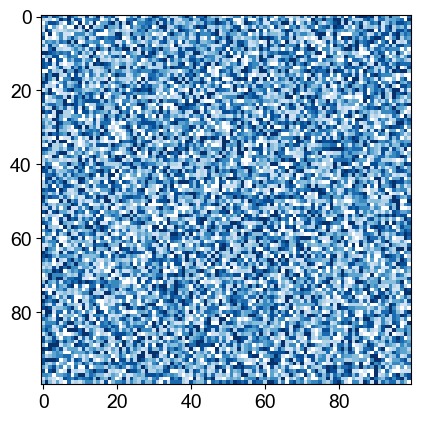

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the colors
colors = ['white'] + [plt.cm.Blues(i) for i in np.linspace(0.2, 1.0, 8)]

# Create and register the colormap
custom_cmap = mcolors.ListedColormap(colors, name='blues_categorical_v2')
plt.register_cmap(name='blues_categorical_v2', cmap=custom_cmap)

# printing example of the created colormap
abc = np.random.randint(0, 9, size=(100, 100))
plt.imshow(abc, cmap='blues_categorical_v2')  # or pass cmap to plot_cortical


##### PLOTTING EPI ROIS

In [ ]:
# Apply transformations
reorganized_plot = parcel_to_surface(reorganize_rois(reorder_hemispheres(mask_epi)), 'aparc_fsa5', fill= np.nan)

# Generate the cortical plot and save as an image
plot_cortical(array_name=reorganized_plot, surface_name="fsa5", size=(6000, 3200),
              background=(1,1,1), transparent_bg=False, interactive=False, cmap='blues_categorical_v2', nan_color=(1, 1, 1, 1),
              color_bar=True, scale=(1,1), zoom=1.25)

##### PLOTTING NON-EPI ROIS

In [ ]:
# Apply transformations
reorganized_plot = parcel_to_surface(reorganize_rois(reorder_hemispheres(mask_nonepi)), 'aparc_fsa5', fill= np.nan)

# Generate the cortical plot and save as an image
plot_cortical(array_name=reorganized_plot, surface_name="fsa5", size=(6000, 3200),
              background=(1,1,1), transparent_bg=False, interactive=False, cmap='Reds', nan_color=(1, 1, 1, 1),
              color_bar=True, scale=(1,1), zoom=1.25)
